In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os 
os.chdir('/content/drive/MyDrive/209AS/deepfake/final/')   #replace with your notebook path  

In [8]:
!pip install torch===1.4.0
!pip install torchvision===0.5.0
!pip install numpy>=1.18.1
!pip install scipy>=1.2.1
!pip install scenedetect==0.5.1
!pip install opencv-contrib-python
!pip install python_speech_features
!pip install tensorboardX

## Evaluation for original model (run first line) and LSTM based model (run second line)

Our training results are stored in the folder: our_results. You can use them for test.

In [7]:
!python Multimodal_Detection/train_ori.py --getthresholds './Multimodal_Detection/our_results/DFDC/ori_model_L1+L2.pth.tar'  --batch_size 1 --out_dir './Multimodal_Detection/dataset/DFDC' --loss 2 #make sure the batch here is 1 
#!python Multimodal_Detection/train_lstm.py --getthresholds './Multimodal_Detection/our_results/DFDC/lstm_model_L1+L2.pth.tar'  --batch_size 1 --out_dir './Multimodal_Detection/dataset/DFDC' --loss 2 #testing for lstm based models

thresholds: 0.866599154472351


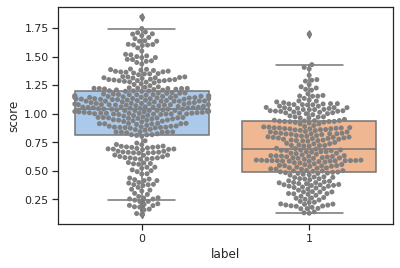

In [7]:
import pickle, numpy as np
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
#import sklearn.external.joblib as extjoblib
import joblib
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.metrics import accuracy_score
# file_dissimilarity_score.pkl contains a dictionary with key as video name and value as the sum of
# dissimilarity scores of all chunks of that video
with open('file_dissimilarity_score_train.pkl', 'rb') as handle:
	test_dissimilarity_score = pickle.load(handle)

# file_target.pkl contains a dictionary with key as video name and value as the true target (real/fake)
# for that video
with open('file_target_train.pkl', 'rb') as handle:
	test_target = pickle.load(handle)

# file_number_of_chunks.pkl contains a dictionary with key as video name and value as the number of chunks
# in that video
with open('file_number_of_chunks_train.pkl', 'rb') as handle:
	test_number_of_chunks = pickle.load(handle)

with open('file_scorelist.pkl', 'rb') as handle:
	test_scorelist = pickle.load(handle)
 
thresholds_real = 0
thresholds_fake = 0
score_fake = []
score_real = []

y_tar = np.zeros((len(test_target),1))
y_pred = np.zeros((len(test_target),1))
count_real = 0
count_fake = 0
for video,score in test_dissimilarity_score.items():
    tar = test_target[video]
    score = test_dissimilarity_score[video]
    num_chunks = test_number_of_chunks[video]
    mean_dissimilarity_score = (score.item()) / num_chunks

    if tar == 1:
        #thresholds_real = thresholds_real + mean_dissimilarity_score
        count_real = count_real+1
        score_real.append(mean_dissimilarity_score)
        
    if tar == 0:
        #thresholds_fake = thresholds_fake + mean_dissimilarity_score
        count_fake = count_fake + 1
        score_fake.append(mean_dissimilarity_score)
        
#thresholds_real = thresholds_real/count_real
#thresholds_fake = thresholds_fake/count_fake

score_real_np = np.array(score_real)
score_fake_np = np.array(score_fake)
score_train = np.hstack((score_real_np,score_fake_np))
label_real = np.ones(len(score_real)).astype(int)
label_fake = np.zeros(len(score_fake)).astype(int)
label_train = np.hstack((label_real,label_fake))


data = {'score':pd.Series(score_train),'label':pd.Series(label_train)}
data = pd.DataFrame(data)
sns.set_theme(style="ticks",palette="pastel")
thresholds_real = np.median(score_real_np)
thresholds_fake = np.median(score_fake_np)
Threshold = (thresholds_real+thresholds_fake)/2
print('thresholds:', Threshold)   #put this thresholds in the test next

ax = sns.boxplot(x='label',y='score',data=data)
ax = sns.swarmplot(x='label',y='score',data=data, color="grey")


In [8]:
#!python Multimodal_Detection/train_ori.py --test './Multimodal_Detection/our_results/DFDC/ori_model_L1+L2.pth.tar' --batch_size 1 --out_dir './Multimodal_Detection/dataset/DFDC' --loss 2
!python Multimodal_Detection/train_lstm.py --test './Multimodal_Detection/our_results/DFDC/lstm_model_L1+L2.pth.tar' --img_dim 96 --batch_size 1 --out_dir './Multimodal_Detection/dataset/DFDC'

Video wise AUC is: 0.8581932773109243
Video wise AUC is: 0.8287815126050418
Video wise AUC is: 0.8466386554621848


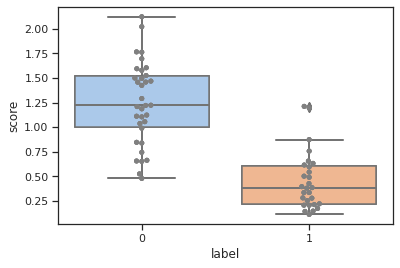

In [11]:
import pickle, numpy as np
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
# file_dissimilarity_score.pkl contains a dictionary with key as video name and value as the sum of
# dissimilarity scores of all chunks of that video 
with open('file_dissimilarity_score.pkl', 'rb') as handle:
	test_dissimilarity_score = pickle.load(handle)

# file_target.pkl contains a dictionary with key as video name and value as the true target (real/fake)
# for that video
with open('file_target.pkl', 'rb') as handle:
	test_target = pickle.load(handle)

# file_number_of_chunks.pkl contains a dictionary with key as video name and value as the number of chunks 
# in that video
with open('file_number_of_chunks.pkl', 'rb') as handle:
	test_number_of_chunks = pickle.load(handle)

#thresholds = [0.5,0.6,0.7,0.8,0.9]#2.6 epoch37 61%;1.4 epoch39 74%; 1.3 epoch40 71%; 1.35 epoch41 70%
#noloss3: 0.7 epoch20 71%; 0.6 epoch21 77.8%; 
with open('file_scorelist_test.pkl', 'rb') as handle:
	test_scorelist = pickle.load(handle)
thresholds = [Threshold-0.1,Threshold,Threshold+0.1]
for threshold in thresholds:
	y_tar = np.zeros((len(test_target),1))
	y_pred = np.zeros((len(test_target),1))
	count = 0
	score_fake = []
	score_real = []
	var_fake = []
	var_real = []
	lst_fake = []
	lst_real = []
	for video,score in test_dissimilarity_score.items():
		tar = test_target[video]
		score = test_dissimilarity_score[video]
		num_chunks = test_number_of_chunks[video]
		#print(num_chunks)
		mean_dissimilarity_score = (score.item()) / num_chunks
		lst = test_scorelist[video]
		lst = np.array(lst)

		if tar == 0:
			score_fake.append(mean_dissimilarity_score)
		else:
			score_real.append(mean_dissimilarity_score)
		if mean_dissimilarity_score >= threshold:
			# predicted target is fake
			pred = 0
		else:
			# predicted target is real
			pred = 1
		
		y_tar[count,0] = tar
		y_pred[count,0] = pred
		count = count + 1
	score_fake = np.array(score_fake)
	score_real = np.array(score_real)
	#data = [score_fake,score_real]
	score = np.hstack((score_fake,score_real))
	y_fake = np.zeros(len(score_fake)).astype(int)
	y_real = np.ones(len(score_real)).astype(int)
	label = np.hstack((y_fake,y_real))
	data = {'score':pd.Series(score),'label':pd.Series(label)}
	data = pd.DataFrame(data)
	
	sns.set_theme(style="ticks",palette="pastel")
	ax = sns.boxplot(x='label',y='score',data=data)
	ax = sns.swarmplot(x='label',y='score',data=data, color="grey")

	print('Video wise AUC is: '+str(roc_auc_score(y_tar, y_pred)))

